<a href="https://colab.research.google.com/github/my-best/management_analysis/blob/main/2411_%E4%BA%88%E5%AE%9F%E8%AA%A4%E5%B7%AE%E5%88%86%E6%9E%90_%E3%82%B3%E3%83%B3%E3%83%86%E3%83%B3%E3%83%84%E5%88%A5%E7%99%BA%E7%94%9F%E5%A3%B2%E4%B8%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting-Up


In [ ]:
# ===========================
# 環境設定
# ============================
GCP_PRJ_ID = 'neon-shelter-285307'
import os
from pathlib import Path
import importlib
import sys
if 'google.colab' in sys.modules: # Colab環境
    from google.colab import auth
    auth.authenticate_user()

    from google.colab import data_table
    data_table.enable_dataframe_formatter()

    # 日本語文字化け対策
    !pip install japanize-matplotlib -q > /dev/null
    # 統計計算用
    !pip install pingouin -q > /dev/null

# ============================
# ノートブック共通設定
# ============================
# 標準ライブラリ
import warnings
warnings.simplefilter('ignore')

# データ分析系
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

!pip install ydata-profiling
import ydata_profiling as ydp

# データ可視化
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from summarytools import dfSummary as summary
# ----------------------------------------
# set display style
# ----------------------------------------
# Notebookの表示設定
from tqdm.notebook import tqdm
from IPython.display import display, Markdown,Latex
import textwrap
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.options.display.float_format = '{:.4f}'.format

plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8, 6)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=688392745847337dae2f7a7403030c8d340a6567e2653539ac0a0b212e1f2054
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
# グラフを描画する関数を定義
def plot_hist(
    x,
    bins=30,
    title='',
    xlabel='',
    ylabel='',
    fontsize=15,
    describe=True,
    desc_inverse=False,
    log=False,
    conv_log=False,
    show_head=False,
    show_tail=False,
    remove_outlier=None,
    kde =False
):
    fig = plt.figure(figsize=(9, 6))
    if remove_outlier:
        mask  = x > x.quantile(remove_outlier)
        mask &= x < x.quantile(1-remove_outlier)
        x = x[mask]

    if conv_log == 'log1p':
        x = np.log1p(x)
    elif conv_log:
        x = np.log10(x)

    # plothist
    ax = x.hist(bins=bins,log=log)
    if kde:
        x.plot.kde(ax=ax, secondary_y=True)
    plt.title(title,fontsize=fontsize)
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)

    if describe:
        txt = x.describe()
        if desc_inverse:
            txt[1:] = txt[1:].map(lambda x:10**x)
        txt = txt.map('{:.2e}'.format).to_string()
        if desc_inverse:
            txt = '< inversed describe >\n' + txt
        fig.text(0.95,0.5,txt,fontsize=fontsize)
    if show_head > 0:
        x_topn = tabulate(x.nlargest(show_head).reset_index(), headers='keys', tablefmt='pretty')
        print(f'< Top{show_head} >\n',x_topn)
    if show_tail > 0:
        x_bottomn = tabulate(x.nsmallest(show_head).reset_index(), headers='keys', tablefmt='pretty')
        print(f'< Bottom{show_tail} >\n',x_bottomn)
    plt.show()
    return ax

def plot_ts(x,
    title='',
    xlabel='',
    ylabel='',
    fontsize=15,
    window_nums=[5, 25, 90],
    how='mean',
    show_legend=True,
    plot_raw=True  # 生データをプロットするかどうかのフラグ
):
    res = []

    # インデックスをdatetime型にする
    x.index = x.index.astype('datetime64[ns]')
    # 生データをプロットする場合、リストに追加
    if plot_raw:
        res.append(x)

    # 移動平均の計算と格納
    if len(window_nums) > 0:
        for i in window_nums:
            if how == 'mean':
                ts = x.rolling(i).mean()
                ts.name = f'{how}_window_{i}'
                res.append(ts)

    # プロットの準備
    fig, ax = plt.subplots(figsize=(12, 8))
    fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(fmt)

    # 各時系列をプロット
    for ts in res:
        ax.plot(ts.index, ts, label=ts.name)

    # タイトル、ラベルの設定
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    # グリッドと回転の設定
    ax.grid(True)
    plt.xticks(rotation=90)

    # 凡例の表示設定
    if show_legend:
        ax.legend()

    plt.show()

# 予実GAP分析

## データセットの取得

In [ ]:
# 予実データの取得
df = pd.read_gbq(
  '''
  select
    page_path as `ページパス`,
    merchandise as `商材名`,
    case
      when cate_1="物販" then "物販"
      when coverage in ("クレジットカード","カードローン","脱毛","格安SIM","インターネット回線","ウォーターサーバー") then "金融・サービス_注力領域"
      else "金融・サービス_その他"
    end as `区分`,
    safe_divide(referral_fee_prov_plain_all-referral_fee_prov_plain_all_est,referral_fee_prov_plain_all_est) as `予実誤差_プレーン発生売上`,
    safe_divide(sessions_plain-sessions_plain_est,sessions_plain_est) as `予実誤差_プレーンセッション数`,
    safe_divide(session_coefficient-session_coefficient_est,session_coefficient_est) as `予実誤差_セッション係数`,
    1/rank_target_keyword - 1/rank_target_keyword_est as `予実誤差_検索順位`,
    safe_divide(fee_per_session_prov_plain-fee_per_session_prov_plain_est,fee_per_session_prov_plain_est) as `予実誤差_プレーンセッション単価`,
    cvr_plain_all - cvr_plain_all_est as `予実誤差_プレーンCVR`,
    safe_divide(fee_per_cv_num_prov_plain - fee_per_cv_num_prov_plain_est,fee_per_cv_num_prov_plain_est) as `予実誤差_プレーンCV単価`,
    referral_fee_prov_plain_all as `プレーン発生売上実績`,
    sessions_plain as `プレーンセッション数実績`,
    session_coefficient as `セッション係数実績`,
    cv_num_plain_all as `プレーンCV数実績`,
    rank_target_keyword as `検索順位実績`,
    fee_per_session_prov_plain as `プレーンセッション単価実績`,
    referral_fee_prov_plain_all_est as `プレーン発生売上予算`,
    sessions_plain_est as `プレーンセッション数予算`,
    session_coefficient_est as `セッション係数予算`,
    cv_num_plain_all_est as `プレーンCV数予算`,
    rank_target_keyword_est as `検索順位予算`,
    fee_per_session_prov_plain_est as `プレーンセッション単価予算`,
    case
      when cate_1="物販" then 1
      else 0
    end as `物販フラグ`,
    case
      when cate_1="サービス" then 1
      else 0
    end as `サービスフラグ`
  from
    warehouse.metrics_per_page_path_monthly
  where month = date(2024,10,1)
  '''
,project_id=GCP_PRJ_ID,dialect='standard',use_bqstorage_api=True)

df['予実誤差_プレーン発生売上_対数変換'] = np.log1p(df['予実誤差_プレーン発生売上'])
df['予実誤差_プレーンセッション数_対数変換'] = np.log1p(df['予実誤差_プレーンセッション数'])
df['予実誤差_セッション係数_対数変換'] = np.log1p(df['予実誤差_セッション係数'])
df['予実誤差_検索順位_対数変換'] = np.log1p(df['予実誤差_検索順位'])
df['予実誤差_プレーンセッション単価_対数変換'] = np.log1p(df['予実誤差_プレーンセッション単価'])
df['予実誤差_プレーンCVR_対数変換'] = np.log1p(df['予実誤差_プレーンCVR'])
df['予実誤差_プレーンCV単価_対数変換'] = np.log1p(df['予実誤差_プレーンCV単価'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# 区分ごとのdataframeを作成
# 物販と金融・サービス_その他を入れ込む
df_target = df[df['区分'].isin(["物販", "金融・サービス_その他"])]
df_target.dropna(inplace=True)
df_target.reset_index(drop=True, inplace=True)

df_target['target'] = df_target['予実誤差_プレーン発生売上_対数変換']
df_target.drop(columns=['予実誤差_プレーン発生売上_対数変換'],inplace=True)

# 物販
df_mer= df[df['区分']=="物販"]
df_mer.dropna(inplace=True)
df_mer.reset_index(drop=True, inplace=True)

df_mer['target'] = df_mer['予実誤差_プレーン発生売上_対数変換']
df_mer.drop(columns=['予実誤差_プレーン発生売上_対数変換'],inplace=True)

# 金融・サービス_その他
df_ser_other= df[df['区分']=="金融・サービス_その他"]
df_ser_other.dropna(inplace=True)
df_ser_other.reset_index(drop=True, inplace=True)

df_ser_other['target'] = df_ser_other['予実誤差_プレーン発生売上_対数変換']
df_ser_other.drop(columns=['予実誤差_プレーン発生売上_対数変換'],inplace=True)

## データセットの特徴量の可視化

- 学習に用いる目的変数・説明変数に関して、探索を行う

In [ ]:
# サンプル数
print("サンプル数")
print("物販:",len(df_mer))
print("金融・サービス_その他:",len(df_ser_other))

サンプル数
物販: 10348
金融・サービス_その他: 809


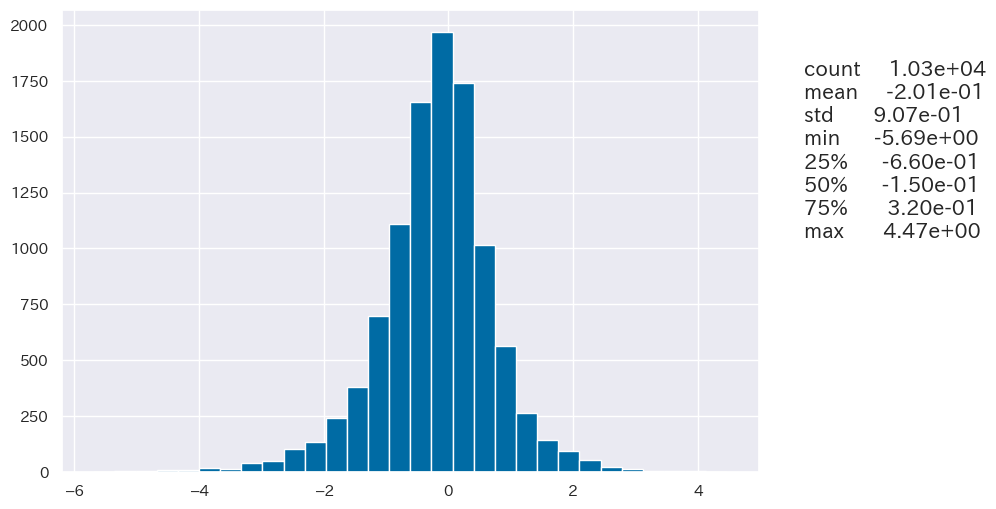

<Axes: >

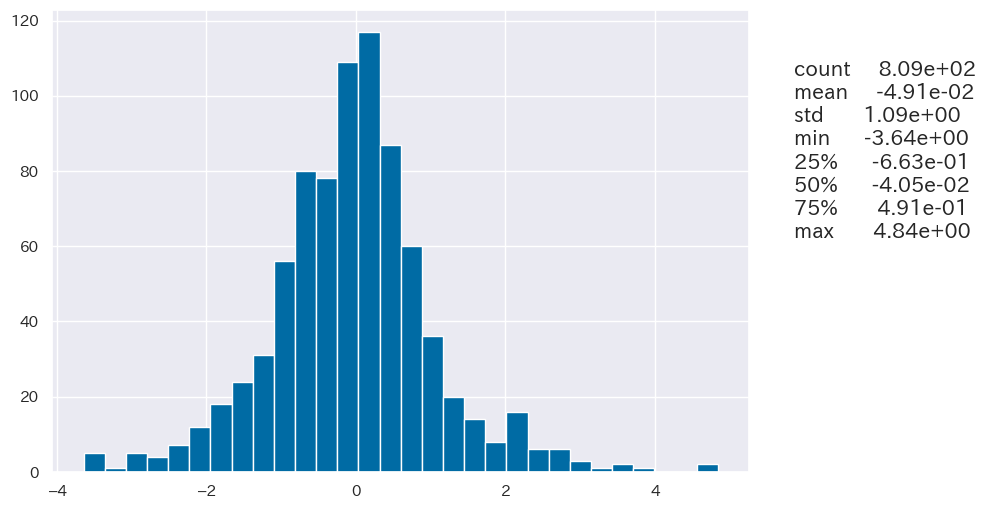

<Axes: >

In [ ]:
# 目的変数の分布を確認する
plot_hist(df_mer.target)
plot_hist(df_ser_other.target)

- 発生売上の予実誤差は対数正規分布に従っている

<Figure size 1000x800 with 0 Axes>

<Axes: >

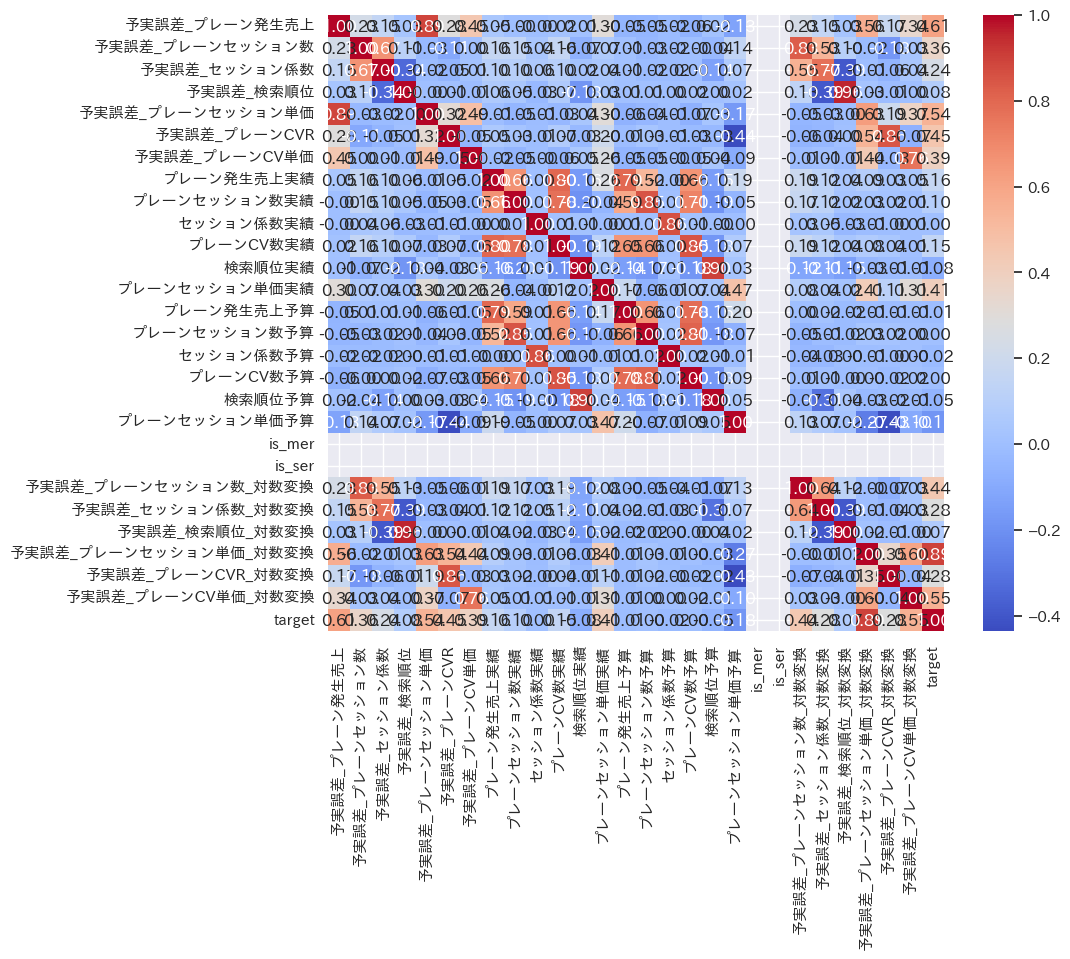

<Figure size 1000x800 with 0 Axes>

<Axes: >

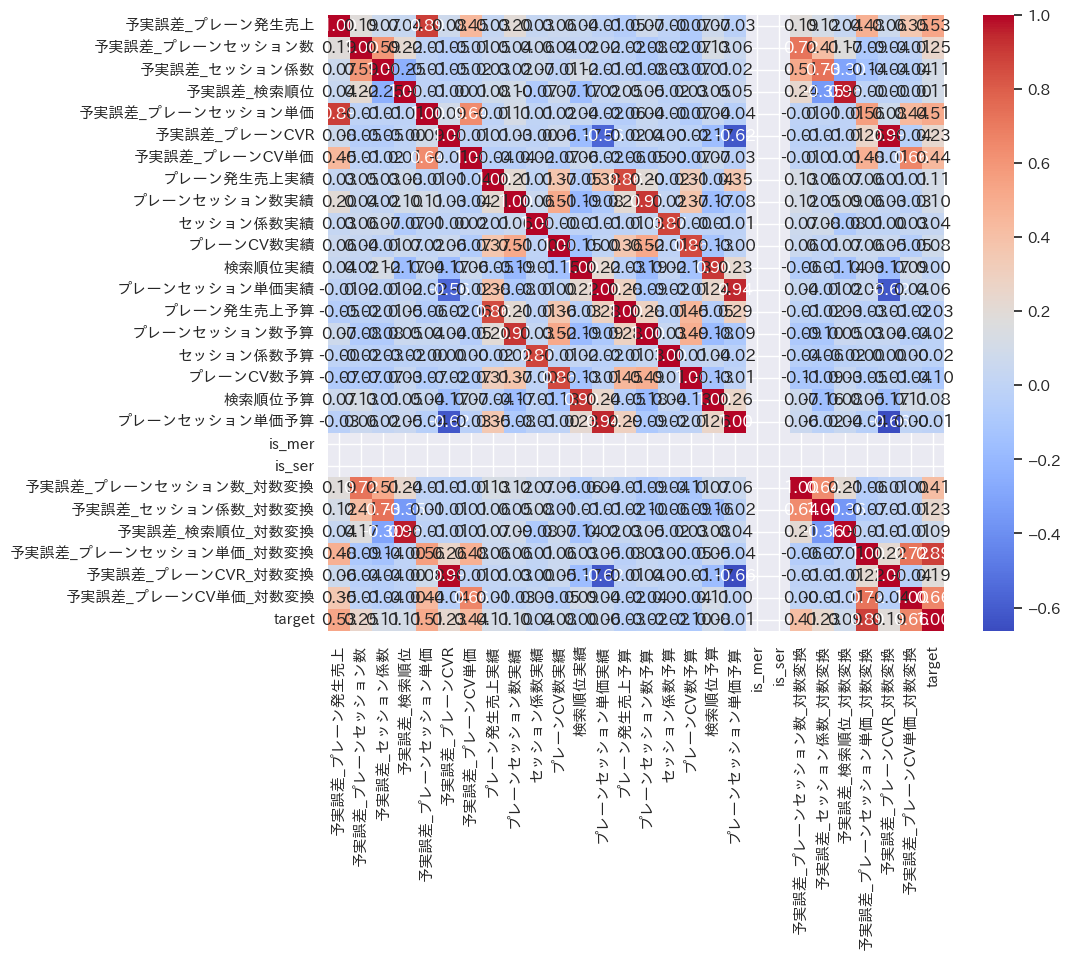

In [ ]:
# ヒートマップの描画
correlation_matrix_mer = df_mer.drop(columns=['ページパス', '商材名','区分']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_mer, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.show()

correlation_matrix_ser_other = df_ser_other.drop(columns=['ページパス', '商材名','区分']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_ser_other, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.show()

- 以下の変数が発生売上の予実誤差と特に正の相関が強い
  - セッション単価の予実誤差
  - CV単価の予実誤差

In [ ]:
#基本的な特徴量の抽出
df_mer.describe()
df_ser_other.describe()

,予実誤差_プレーン発生売上,予実誤差_プレーンセッション数,予実誤差_セッション係数,予実誤差_検索順位,予実誤差_プレーンセッション単価,予実誤差_プレーンCVR,予実誤差_プレーンCV単価,プレーン発生売上実績,プレーンセッション数実績,セッション係数実績,プレーンCV数実績,検索順位実績,プレーンセッション単価実績,プレーン発生売上予算,プレーンセッション数予算,セッション係数予算,プレーンCV数予算,検索順位予算,プレーンセッション単価予算,is_mer,is_ser,予実誤差_プレーンセッション数_対数変換,予実誤差_セッション係数_対数変換,予実誤差_検索順位_対数変換,予実誤差_プレーンセッション単価_対数変換,予実誤差_プレーンCVR_対数変換,予実誤差_プレーンCV単価_対数変換,target
count,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000,10348.0000
mean,0.2359,0.0150,0.1005,0.0357,0.2503,-0.0022,0.1092,11684.7642,2279.2127,19.7619,64.3757,3.6621,5.6121,12008.9124,2333.7773,20.0658,65.3986,3.8373,6.0295,1.0000,0.0000,-0.0720,-0.0538,0.0228,-0.1288,-0.0027,-0.0506,-0.2008
std,1.9779,0.5566,0.7944,0.1579,1.9146,0.0235,0.9242,28288.8813,4659.8372,154.1562,137.0126,3.8177,5.3469,30040.8744,5096.8383,169.5978,134.2568,3.8233,5.9791,0.0000,0.0000,0.4053,0.5532,0.1638,0.8131,0.0389,0.5352,0.9068
min,-0.9966,-0.9457,-0.9813,-0.8837,-0.9942,-0.9623,-0.9850,5.0000,13.0000,0.0357,1.0000,1.0000,0.0096,9.0000,13.0000,0.1500,1.0000,1.0000,0.0446,1.0000,0.0000,-2.9127,-3.9771,-2.1518,-5.1466,-3.2774,-4.1997,-5.6940
25%,-0.4831,-0.2592,-0.2862,0.0000,-0.3944,-0.0096,-0.2366,1329.0000,394.0000,2.5093,8.0000,1.0000,2.1822,1786.5000,456.7500,2.6800,10.0000,1.0000,2.5830,1.0000,0.0000,-0.3000,-0.3371,0.0000,-0.5015,-0.0097,-0.2699,-0.6600
50%,-0.1394,-0.0658,-0.0236,0.0000,-0.0878,-0.0014,-0.0427,3939.5000,946.0000,5.1899,23.0000,2.2000,4.2843,4748.0000,1027.5000,5.4400,27.0000,3.0000,4.7135,1.0000,0.0000,-0.0681,-0.0239,0.0000,-0.0919,-0.0014,-0.0436,-0.1501
75%,0.3769,0.1762,0.3047,0.0513,0.3198,0.0062,0.1943,10923.7500,2318.2500,11.8383,63.0000,4.4000,7.4365,11598.0000,2376.0000,11.9825,68.0000,5.0000,7.7633,1.0000,0.0000,0.1623,0.2660,0.0500,0.2774,0.0061,0.1776,0.3198
max,86.6429,22.0369,25.3206,0.8571,84.4542,0.2914,26.7895,757059.0000,140052.0000,6648.9362,3574.0000,20.0000,110.6577,1441109.0000,256522.0000,8526.3200,5313.0000,30.0000,176.0000,1.0000,0.0000,3.1371,3.2704,0.6190,4.4480,0.2557,3.3247,4.4733


,予実誤差_プレーン発生売上,予実誤差_プレーンセッション数,予実誤差_セッション係数,予実誤差_検索順位,予実誤差_プレーンセッション単価,予実誤差_プレーンCVR,予実誤差_プレーンCV単価,プレーン発生売上実績,プレーンセッション数実績,セッション係数実績,プレーンCV数実績,検索順位実績,プレーンセッション単価実績,プレーン発生売上予算,プレーンセッション数予算,セッション係数予算,プレーンCV数予算,検索順位予算,プレーンセッション単価予算,is_mer,is_ser,予実誤差_プレーンセッション数_対数変換,予実誤差_セッション係数_対数変換,予実誤差_検索順位_対数変換,予実誤差_プレーンセッション単価_対数変換,予実誤差_プレーンCVR_対数変換,予実誤差_プレーンCV単価_対数変換,target
count,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000
mean,1.0539,0.1723,0.2309,0.0342,0.8270,-0.0011,0.3903,28202.1595,2928.0742,24.7822,23.4054,3.0524,21.9256,26327.6205,2920.0124,23.7221,24.4932,3.1755,22.5311,0.0000,1.0000,-0.0109,0.0327,0.0161,-0.0382,-0.0013,0.0302,-0.0491
std,6.6037,1.3469,1.1413,0.1895,5.1144,0.0189,2.2043,78462.9952,5233.4166,110.5396,50.7334,3.4553,82.4274,74460.8709,4905.8280,132.6528,52.2478,3.4521,86.6841,0.0000,0.0000,0.5052,0.5703,0.1941,0.9938,0.0224,0.6935,1.0886
min,-0.9737,-0.9673,-0.9627,-0.8214,-0.9911,-0.4167,-0.9737,1.0000,10.0000,0.0643,1.0000,1.0000,0.0009,3.0000,15.0000,0.2600,1.0000,1.0000,0.0022,0.0000,1.0000,-3.4196,-3.2894,-1.7228,-4.7179,-0.5390,-3.6376,-3.6376
25%,-0.4847,-0.2438,-0.2274,0.0000,-0.4017,-0.0030,-0.2151,540.0000,542.0000,3.1738,3.0000,1.0000,0.4218,632.0000,561.0000,3.1500,3.0000,1.0000,0.4912,0.0000,1.0000,-0.2795,-0.2580,0.0000,-0.5136,-0.0030,-0.2422,-0.6630
50%,-0.0397,-0.0301,0.0451,0.0000,-0.0552,-0.0002,0.0003,2178.0000,1293.0000,6.5886,8.0000,1.8000,2.0710,2553.0000,1295.0000,6.2100,8.0000,2.0000,2.2128,0.0000,1.0000,-0.0305,0.0441,0.0000,-0.0568,-0.0002,0.0003,-0.0405
75%,0.6335,0.2239,0.3865,0.0441,0.5296,0.0018,0.3136,15700.0000,3184.0000,15.0668,23.0000,3.4000,11.5055,14461.0000,3205.0000,13.4100,24.0000,4.0000,11.4116,0.0000,1.0000,0.2021,0.3268,0.0432,0.4250,0.0018,0.2727,0.4907
max,125.2000,22.6098,22.2024,0.8750,88.2605,0.1092,37.3333,787800.0000,59591.0000,2218.9055,705.0000,20.0000,1742.6667,890786.0000,45931.0000,3412.1200,594.0000,25.0000,1834.0667,0.0000,1.0000,3.1617,3.1443,0.6286,4.4916,0.1036,3.6463,4.8379


## 予測モデルの可視化

関数の定義

In [ ]:
def lgb_model(df):
    # 特徴量とターゲットの分離
    l_exp = [
        '予実誤差_セッション係数_対数変換',
        '予実誤差_検索順位_対数変換',
        '予実誤差_プレーンCVR_対数変換',
        '予実誤差_プレーンCV単価_対数変換',
        'プレーン発生売上実績',
        'プレーンセッション数実績',
        'セッション係数実績',
        'プレーンCV数実績',
        '検索順位実績',
        'プレーンセッション単価実績',
        '物販フラグ',
        'サービスフラグ'
    ]

    X = df[l_exp]
    y = df['target']
    print("サンプル数: ", len(X))

    # クロスバリデーションの設定
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_list, r2_list = [], []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")

        # 訓練データとテストデータの分割
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # LightGBMデータセットの作成
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        # モデルのパラメータ設定
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.1,
            'num_leaves': 31,
            'verbose': -1
        }

        # モデルの学習
        model = lgb.train(params, train_data, valid_sets=[test_data])

        # テストデータで予測
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # RMSEとR²を計算
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # 全体の平均スコアを計算
    print(f"\n平均 RMSE: {sum(rmse_list) / n_splits:.4f}")
    print(f"平均 R²: {sum(r2_list) / n_splits:.4f}")

    # 最終モデルの学習とSHAP値の計算
    final_model = lgb.train(params, lgb.Dataset(X, label=y))
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X)

    shap.summary_plot(shap_values, X)
    shap.summary_plot(shap_values, X, plot_type='bar')

    # SHAPデータフレームの作成
    columns_shap = ["shap_" + i for i in l_exp]
    df_shap = pd.DataFrame(shap_values, columns=columns_shap)
    df_shap['max_shap_column'] = df_shap.apply(lambda row: row.abs().idxmax(), axis=1)
    mapping = {'shap_予実誤差_プレーンCVR_対数変換': 'CVR', 'shap_予実誤差_検索順位_対数変換': '検索順位', 'shap_予実誤差_プレーンCV単価_対数変換': 'CV単価', 'shap_予実誤差_セッション係数_対数変換': 'セッション係数'}
    df_shap['GAP影響が最も大きい因子'] = df_shap['max_shap_column'].map(mapping).fillna('その他')


    # 元のデータフレームと結合
    X_shap = pd.concat([df, df_shap], axis=1)

    return X_shap

**予測モデルのサマリ**
- 「金融・サービス_注力領域」を除いたコンテンツでモデルを構築
  - サンプル数は11,157コンテンツ
- 発生売上の予実誤差を目的変数、他の変数の予実誤差や実績値を説明変数に置いてモデルを構築
- 決定係数は0.9ほどで精度の良いモデルとなっている
- 全体傾向として、以下の要因が発生売上の予実誤差に大きく影響を与えている
  - CVRの予実誤差
  - CV単価の予実誤差
  - セッション係数の予実誤差
- 順位の予実誤差は上記の3要因と比較して、発生売上予実誤差に与える影響が小さい結果となった
- 個別のコンテンツの詳細な数字とコンテンツごとの発生売上の予実誤差に影響が大きい因子の一覧は以下
  - https://docs.google.com/spreadsheets/d/1kNvbqEVuWS7SupHW3ny4L9gPi0Bhk68dNXsG0tf323g/edit?gid=0#gid=0

サンプル数:  11157
Fold 1/5
Fold 1 RMSE: 0.2535, R²: 0.9243
Fold 2/5
Fold 2 RMSE: 0.2604, R²: 0.9256
Fold 3/5
Fold 3 RMSE: 0.2691, R²: 0.9110
Fold 4/5
Fold 4 RMSE: 0.2672, R²: 0.9154
Fold 5/5
Fold 5 RMSE: 0.2612, R²: 0.9178

平均 RMSE: 0.2623
平均 R²: 0.9188


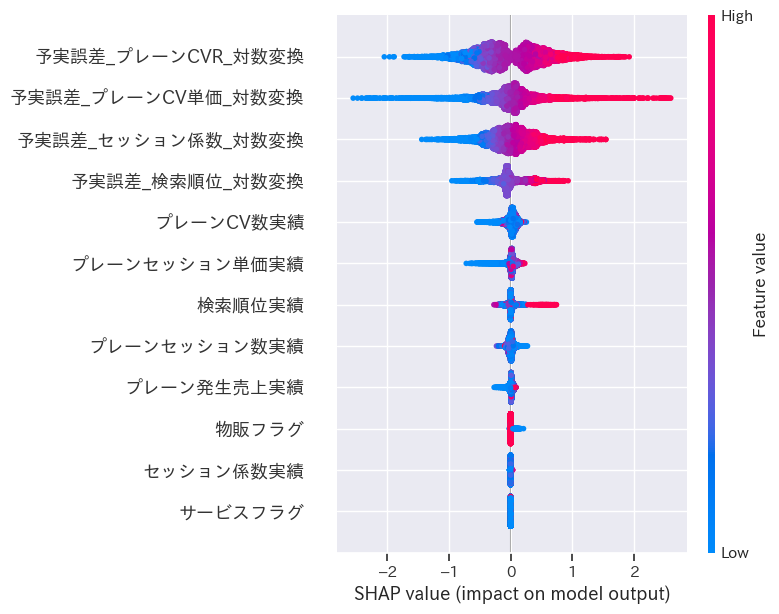

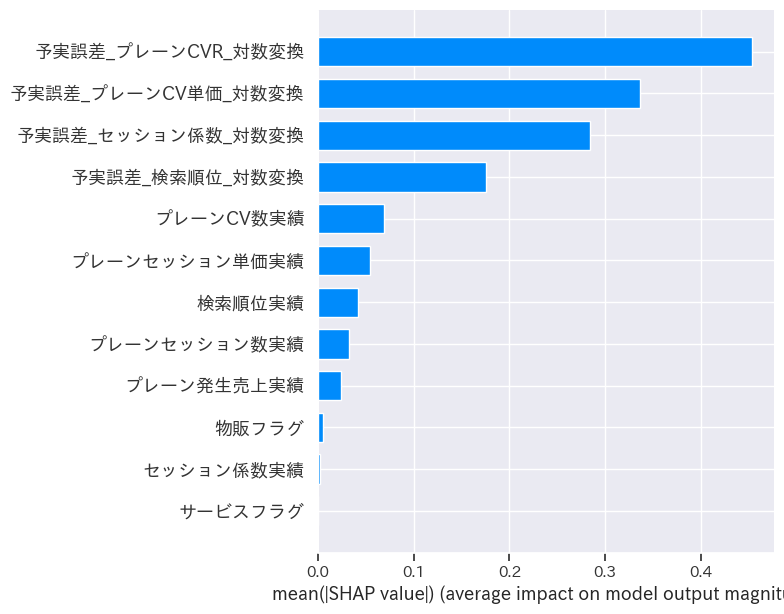

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='max_shap_column'>

Text(0.5, 1.0, 'SHAP値の絶対値が最も大きい因子')

Text(0.5, 0, '因子')

Text(0, 0.5, 'Count')

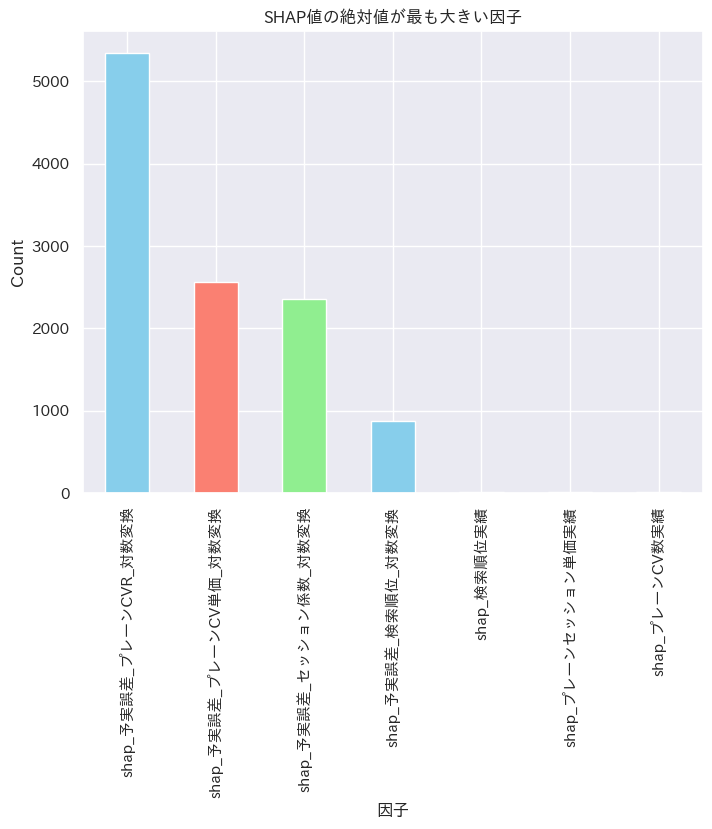

サンプル数:  10348
Fold 1/5
Fold 1 RMSE: 0.2754, R²: 0.9112
Fold 2/5
Fold 2 RMSE: 0.2332, R²: 0.9292
Fold 3/5
Fold 3 RMSE: 0.2508, R²: 0.9268
Fold 4/5
Fold 4 RMSE: 0.2558, R²: 0.9197
Fold 5/5
Fold 5 RMSE: 0.2629, R²: 0.9148

平均 RMSE: 0.2556
平均 R²: 0.9203


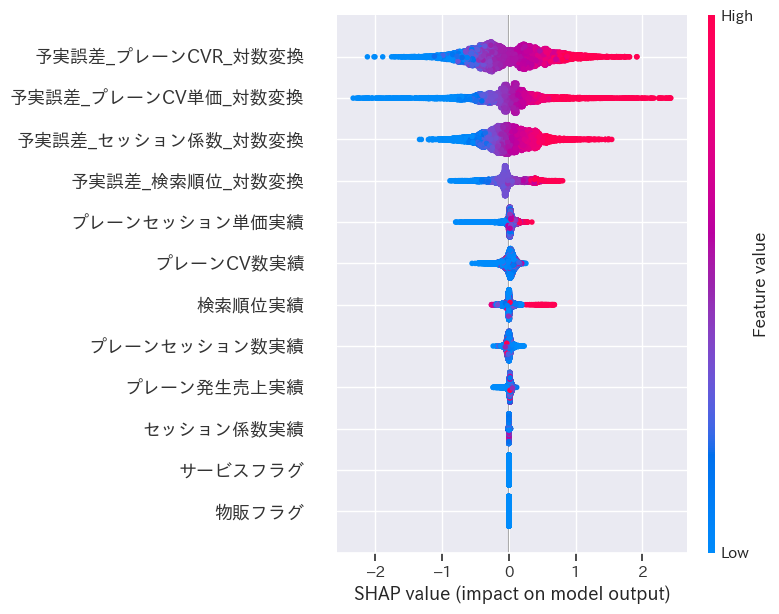

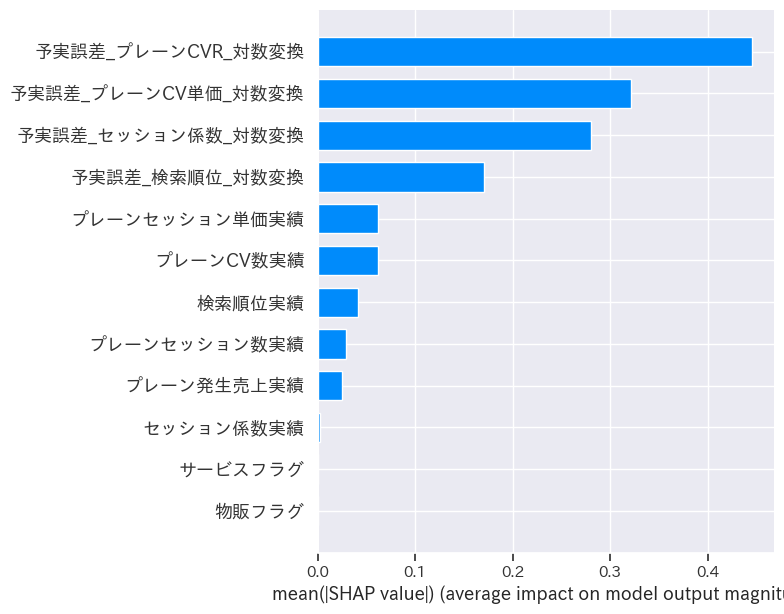

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='max_shap_column'>

Text(0.5, 1.0, 'SHAP値の絶対値が最も大きい因子')

Text(0.5, 0, '因子')

Text(0, 0.5, 'Count')

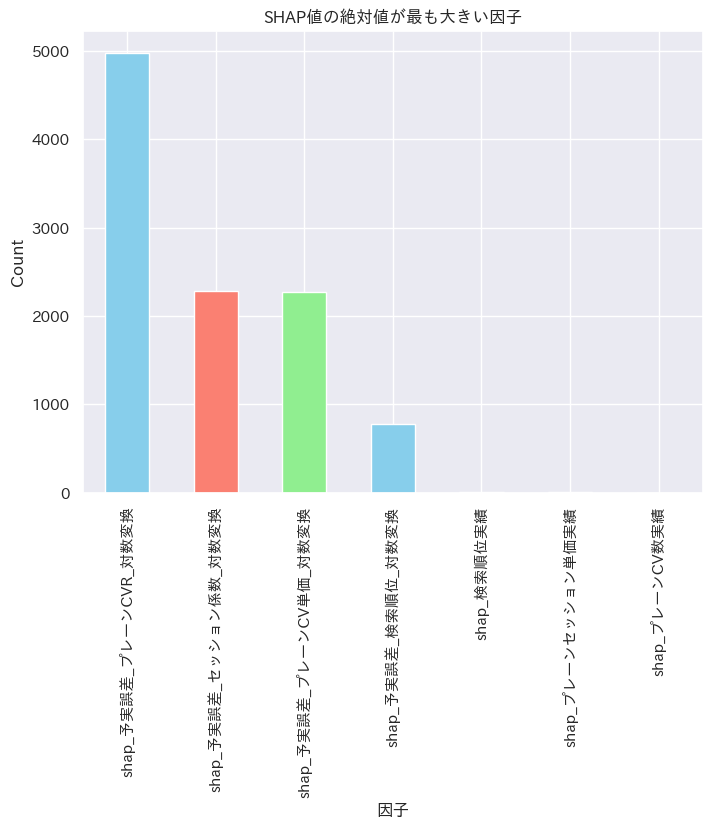

サンプル数:  809
Fold 1/5
Fold 1 RMSE: 0.5031, R²: 0.7864
Fold 2/5
Fold 2 RMSE: 0.4939, R²: 0.8019
Fold 3/5
Fold 3 RMSE: 0.5239, R²: 0.8207
Fold 4/5
Fold 4 RMSE: 0.4966, R²: 0.7836
Fold 5/5
Fold 5 RMSE: 0.3608, R²: 0.8290

平均 RMSE: 0.4757
平均 R²: 0.8043


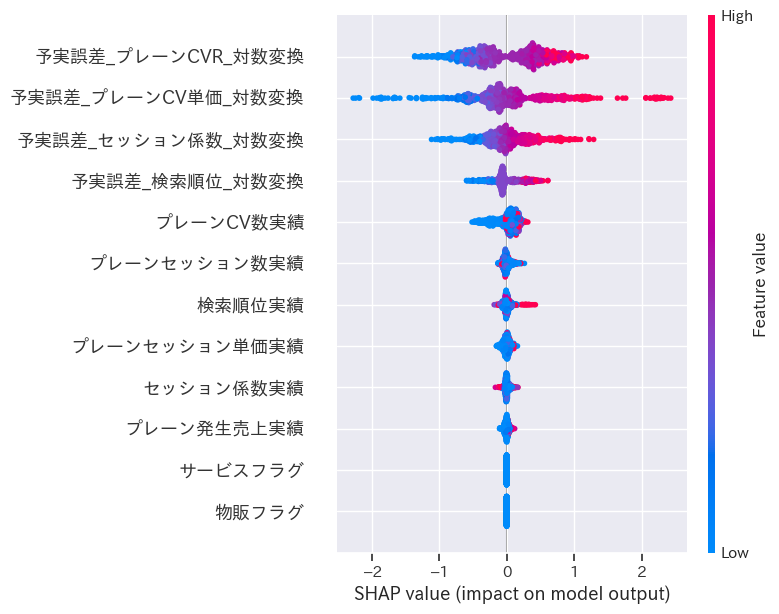

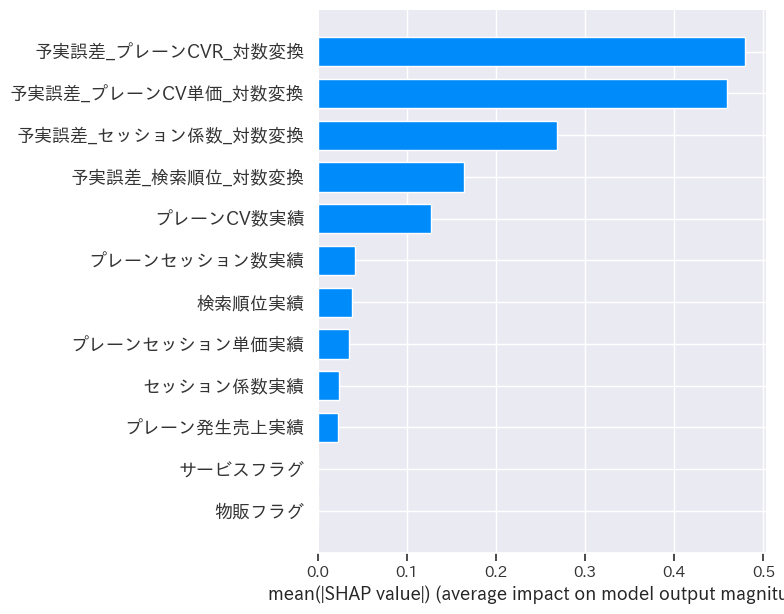

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='max_shap_column'>

Text(0.5, 1.0, 'SHAP値の絶対値が最も大きい因子')

Text(0.5, 0, '因子')

Text(0, 0.5, 'Count')

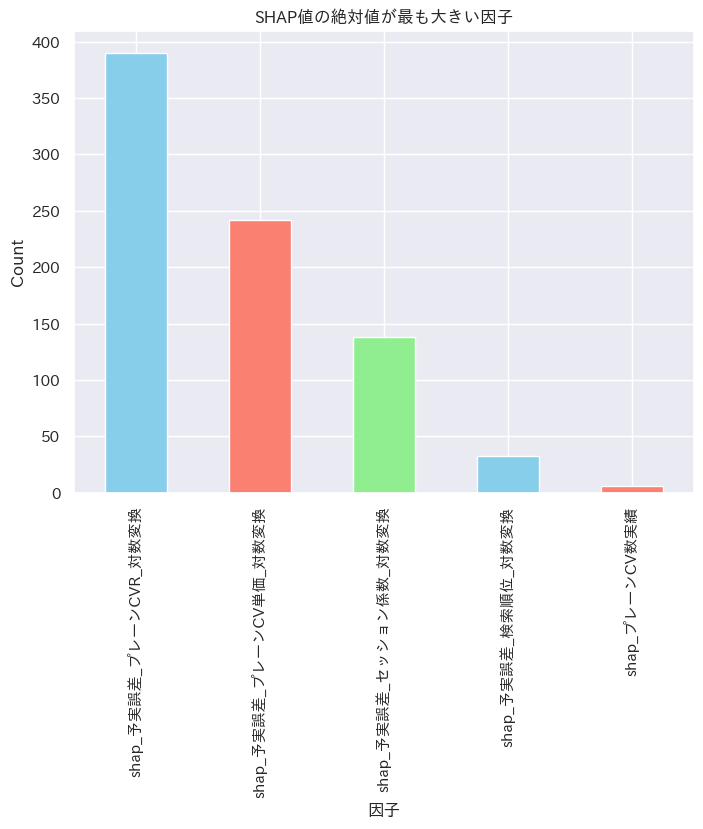

In [ ]:
# ----------------------------------------
# # 物販と金融・サービス_その他の合算
# ----------------------------------------
result_target = lgb_model(df_target)
# SHAP値の絶対値が最も大きいの列名をカウント
value_counts_target = result_target['max_shap_column'].value_counts()

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
value_counts_target.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('SHAP値の絶対値が最も大きい因子')
plt.xlabel('因子')
plt.ylabel('Count')
plt.show()

# ----------------------------------------
# # 物販のみ
# ----------------------------------------
result_mer = lgb_model(df_mer)
# SHAP値の絶対値が最も大きいの列名をカウント
value_counts_mer = result_mer['max_shap_column'].value_counts()

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
value_counts_mer.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('SHAP値の絶対値が最も大きい因子')
plt.xlabel('因子')
plt.ylabel('Count')
plt.show()

# ----------------------------------------
# # 金融・サービス_その他のみ
# ----------------------------------------
result_ser_other = lgb_model(df_ser_other)
# SHAP値の絶対値が最も大きいの列名をカウント
value_counts_ser_other = result_ser_other['max_shap_column'].value_counts()

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
value_counts_ser_other.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('SHAP値の絶対値が最も大きい因子')
plt.xlabel('因子')
plt.ylabel('Count')
plt.show()

In [ ]:
# ファイルの取得
result_target.drop(['target', 'max_shap_column'], axis=1).to_csv('予実誤差モデル出力結果_統合.csv')
result_mer.drop(['target', 'max_shap_column'], axis=1).to_csv('予実誤差モデル出力結果_物販.csv')
result_ser_other.drop(['target', 'max_shap_column'], axis=1).to_csv('予実誤差モデル出力結果_金融・サービス_その他.csv')